<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/Yield_Prediction_Using_Topographical_Features_of_a_Field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import files
uploaded = files.upload()

In [1]:
!pip install rasterio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.7 MB/s eta 0:00:00


In [2]:
#importing all required libraries
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
print(list(uploaded.keys())[0])

NameError: name 'uploaded' is not defined

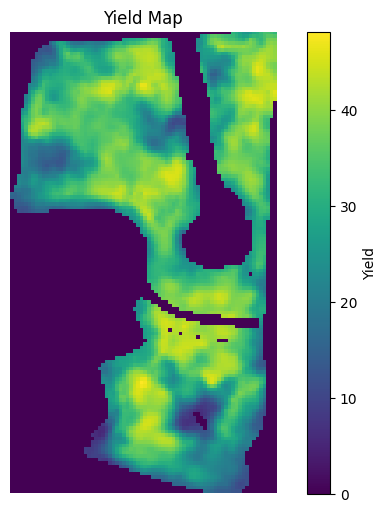

Src:  ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_env', '_gcps', '_get_crs', '_get_rpcs', '_handle_crswkt', '_has_band', '_has_gcps_or_rpcs', '_mask_flags', '_nodatavals', '_offsets', '_read', '_rpcs', '_scales', '_set_all_descriptions', '_set_all_offsets', '_set_all_scales', '_set_all_units', '_set_attrs_from_dataset_handle', '_set_crs', '_set_gcps', '_set_nodatavals', '_set_rpcs', '_transform', '_units', 'block_shapes', 'block_size', 'block_window', 'block_windows', 'bounds', 'checksum', 'close', 'closed', 'colorinterp', 'colorm

In [3]:
# Get the filename from uploaded dictionary
file_name = '/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/CentralFarm_2-71_2022_Soyb_sph_field2rst_kriged.tif'

# Read and visualize the raster
with rasterio.open(file_name) as src:
    yield_raster = src.read(1)  # read the first band
    plt.figure(figsize=(8, 6))
    plt.imshow(yield_raster, cmap='viridis')
    plt.title("Yield Map")
    plt.colorbar(label="Yield")
    plt.axis('off')
    plt.show()


with rasterio.open(file_name) as src:
  print("Src: ", dir(src))
  print("Raster shape:", src.shape)
  print("Data type:", src.dtypes)
  print("CRS:", src.crs)
  print("NoData value:", src.nodata)
  print("Number of bands:", src.count)
  print("Min/Max pixel values (first band):", src.read(1).min(), src.read(1).max())




In [4]:
# Step 1: Get shape of raster
rows, cols = yield_raster.shape

In [5]:
# Step 2: Create a grid of row and column indices
row_indices, col_indices = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

# Step 3: Flatten arrays for tabular format
yield_flat = yield_raster.flatten()
row_flat = row_indices.flatten()
col_flat = col_indices.flatten()

# Step 4: Create DataFrame
df_yield = pd.DataFrame({
    'row': row_flat,
    'col': col_flat,
    'yield': yield_flat
})

# Remove 0.0 yield pixels (they are NoData)
df_yield = df_yield[df_yield['yield'] > 0]

# Optional: Reset index after filtering
df_yield = df_yield.reset_index(drop=True)

#Giving the values of latitude and longitude

with rasterio.open(file_name) as src:
    transform = src.transform
    xs, ys = rasterio.transform.xy(transform, df_yield['row'], df_yield['col'])


df_yield['x'] = xs
df_yield['y'] = ys
# Preview cleaned data
print(df_yield.describe())
print("Valid pixels:", len(df_yield))





               row          col        yield              x             y
count  5841.000000  5841.000000  5841.000000    5841.000000  5.841000e+03
mean     58.351139    43.564116    31.585623  337886.931191  4.320544e+06
std      38.817197    18.863915     8.498373      94.965744  1.950757e+02
min       0.000000     0.000000     5.354946  337667.618362  4.320179e+06
25%      25.000000    30.000000    25.981806  337818.645986  4.320355e+06
50%      47.000000    44.000000    32.964546  337889.125544  4.320601e+06
75%      96.000000    60.000000    38.319359  337969.673610  4.320712e+06
max     131.000000    75.000000    48.159290  338045.187422  4.320838e+06
Valid pixels: 5841


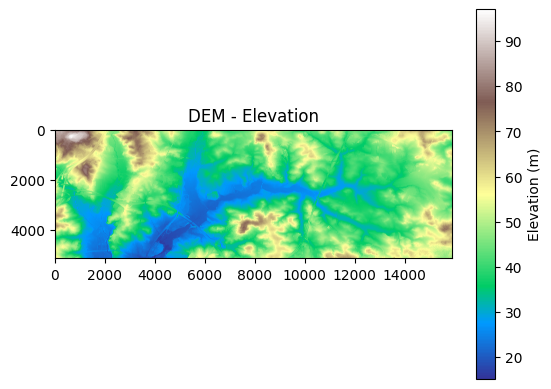

In [6]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/DEM_1m_BARC.tif") as dem:
    elevation = dem.read(1)
    plt.imshow(elevation, cmap="terrain")
    plt.title("DEM - Elevation")
    plt.colorbar(label="Elevation (m)")
    plt.show()


In [7]:
#Checking if the two raster files match

print("\n📊 DEM Raster:")
print(" - CRS:", dem.crs)
print(" - Shape:", dem.shape)
print(" - Transform:", dem.transform)
print(" - Resolution:", dem.res)

print("📊 Yield Raster:")
print(" - CRS:", src.crs)
print(" - Shape:", src.shape)
print(" - Transform:", src.transform)
print(" - Resolution:", src.res)


📊 DEM Raster:
 - CRS: EPSG:4326
 - Shape: (5137, 15881)
 - Transform: | 0.00, 0.00,-76.95|
| 0.00,-0.00, 39.04|
| 0.00, 0.00, 1.00|
 - Resolution: (8.98315284119521e-06, 8.98315284119521e-06)
📊 Yield Raster:
 - CRS: EPSG:32618
 - Shape: (132, 76)
 - Transform: | 5.03, 0.00, 337665.10|
| 0.00,-5.03, 4320840.08|
| 0.00, 0.00, 1.00|
 - Resolution: (5.034254128370728, 5.025495722466572)


### We have come to know that the DEM and Yield raster have different cr, shape and even resolution so we need to project, resample and make it suitable to work together with

In [8]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# File paths
src_dem = "/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/DEM_1m_BARC.tif"
src_yield = "/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/CentralFarm_2-71_2022_Soyb_sph_field2rst_kriged.tif"
dst_dem_resampled = "/content/DEM_resampled.tif"

# Open source DEM and yield raster
with rasterio.open(src_dem) as dem_src, rasterio.open(src_yield) as yield_src:

    # Match target CRS, transform, and shape
    dst_crs = yield_src.crs
    dst_transform = yield_src.transform
    dst_shape = yield_src.shape

    # Prepare metadata for resampled DEM
    dst_meta = dem_src.meta.copy()
    dst_meta.update({
        "crs": dst_crs,
        "transform": dst_transform,
        "width": dst_shape[1],
        "height": dst_shape[0]
    })

    # Reproject and resample
    with rasterio.open(dst_dem_resampled, "w", **dst_meta) as dst:
        reproject(
            source=rasterio.band(dem_src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=dem_src.transform,
            src_crs=dem_src.crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear  # You can also try Resampling.nearest
        )


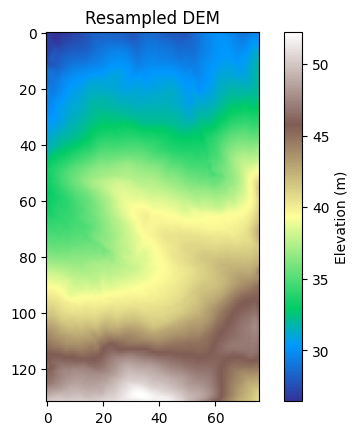

CRS: EPSG:32618
Shape: (132, 76)
Transform: | 5.03, 0.00, 337665.10|
| 0.00,-5.03, 4320840.08|
| 0.00, 0.00, 1.00|


In [9]:
#Let's view the new resampled file
with rasterio.open(dst_dem_resampled) as src:
    resampled_dem = src.read(1)
    plt.imshow(resampled_dem, cmap='terrain')
    plt.title("Resampled DEM")
    plt.colorbar(label="Elevation (m)")
    plt.show()

    print("CRS:", src.crs)
    print("Shape:", src.shape)
    print("Transform:", src.transform)




## We have now resampled and reprojected the elevation data, let's integrate this data into the yield data frame

In [10]:

# Step 1: Open the resampled DEM
with rasterio.open(dst_dem_resampled) as dem_src:

    # Step 2: Create list of (x, y) coordinate pairs
    coords = list(zip(df_yield['x'], df_yield['y']))

    # Step 3: Sample elevation values at those coordinates
    elevation_vals = [val[0] for val in dem_src.sample(coords)]

# Step 4: Add to DataFrame
df_yield['elevation'] = elevation_vals

# Step 5: Preview
(df_yield.head())

,row,col,yield,x,y,elevation
0,0,63,31.364374,337984.776372,4.320838e+06,29.970028
1,0,64,29.821093,337989.810626,4.320838e+06,29.873554
2,0,65,27.940876,337994.844880,4.320838e+06,29.741947
3,0,66,25.964394,337999.879134,4.320838e+06,29.558409
4,0,67,25.181866,338004.913389,4.320838e+06,29.367819


### Now, let's evaluate Slope and Aspect


In [11]:
#whitebox is a Python Library that allwos efficient calculations of slope, aspect, flow direction, watersheds, topographic wenbess index, depression filling, steam extraction and terrain roughness

!pip install whitebox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 2.3 MB/s eta 0:00:00


In [12]:
import whitebox

wbt = whitebox.WhiteboxTools()

# Set the working directory (optional, but helpful)
wbt.set_working_dir("/content/")

wbt.slope(
    dem="DEM_resampled.tif",      # Input DEM
    output="slope.tif",           # Output slope raster
    zfactor=None                  # Optional: Use if elevation is in meters and coordinates are in degrees
)

wbt.aspect(
    dem="DEM_resampled.tif",      # Input DEM
    output="aspect.tif",          # Output aspect raster
    zfactor=None                  # Optional: Use if elevation is in meters and coordinates are in degrees
)


Decompressing WhiteboxTools_linux_musl.zip ...
WhiteboxTools package directory: /usr/local/lib/python3.11/dist-packages/whitebox
./whitebox_tools --run="Slope" --wd="/content" --dem='DEM_resampled.tif' --output='slope.tif' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress:

0

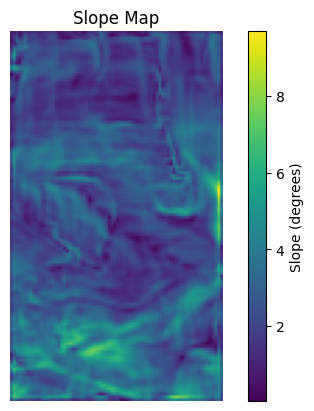

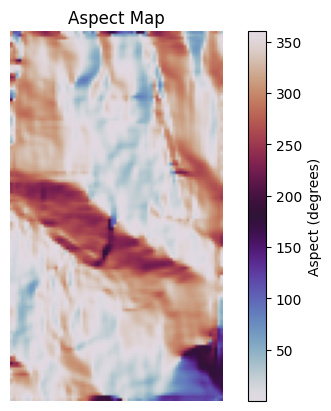

In [13]:
#plotting the slope and aspect files:


with rasterio.open("slope.tif") as src:
    slope = src.read(1)
    plt.imshow(slope, cmap="viridis") #imshow() is used to display images from 2d arrays
    plt.colorbar(label="Slope (degrees)")
    plt.title("Slope Map")
    plt.axis("off")
    plt.show()

with rasterio.open("aspect.tif") as src:
    aspect = src.read(1)
    plt.imshow(aspect, cmap="twilight")
    plt.colorbar(label="Aspect (degrees)")
    plt.title("Aspect Map")
    plt.axis("off")
    plt.show()

### Let's integrate this into the yield data as well

In [14]:
with rasterio.open("slope.tif") as slope_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    slope_vals = [val[0] for val in slope_src.sample(coords)]

with rasterio.open("aspect.tif") as aspect_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    aspect_vals = [val[0] for val in aspect_src.sample(coords)]

df_yield['slope'] = slope_vals
df_yield['aspect'] = aspect_vals
df_yield.head()

,row,col,yield,x,y,elevation,slope,aspect
0,0,63,31.364374,337984.776372,4.320838e+06,29.970028,0.862994,45.548988
1,0,64,29.821093,337989.810626,4.320838e+06,29.873554,1.250407,59.525551
2,0,65,27.940876,337994.844880,4.320838e+06,29.741947,1.508874,67.985176
3,0,66,25.964394,337999.879134,4.320838e+06,29.558409,1.667183,66.825592
4,0,67,25.181866,338004.913389,4.320838e+06,29.367819,1.695179,64.340607


## Histogram of Yield

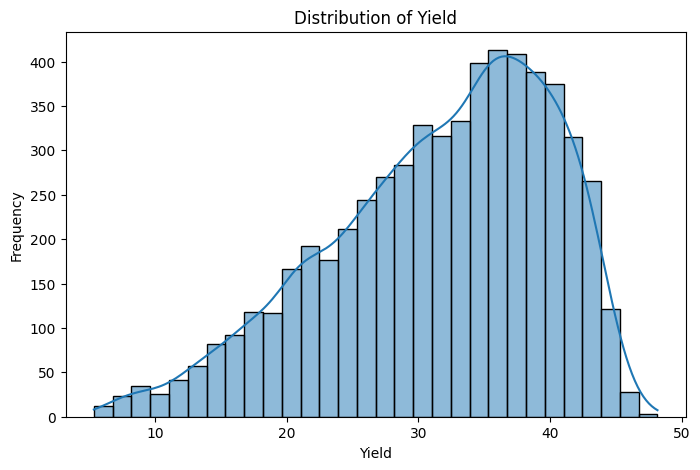

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_yield['yield'], bins=30, kde=True)
plt.title("Distribution of Yield")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()


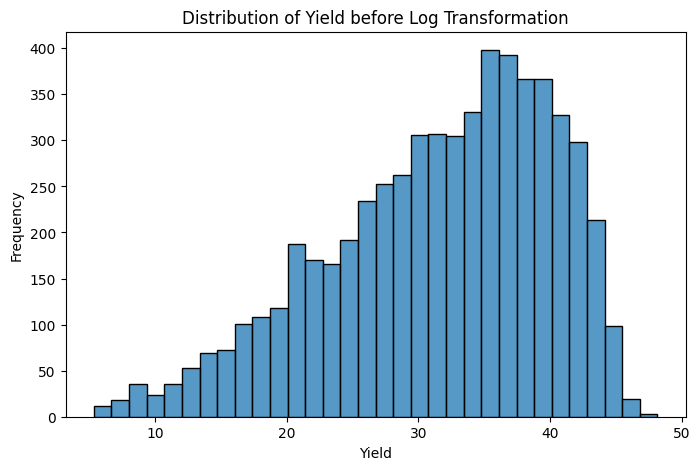

In [16]:
# the existing data:
plt.figure(figsize=(8, 5))
sns.histplot(df_yield['yield'])
plt.title("Distribution of Yield before Log Transformation")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()



## Scatter Plot of Yield vs Slope

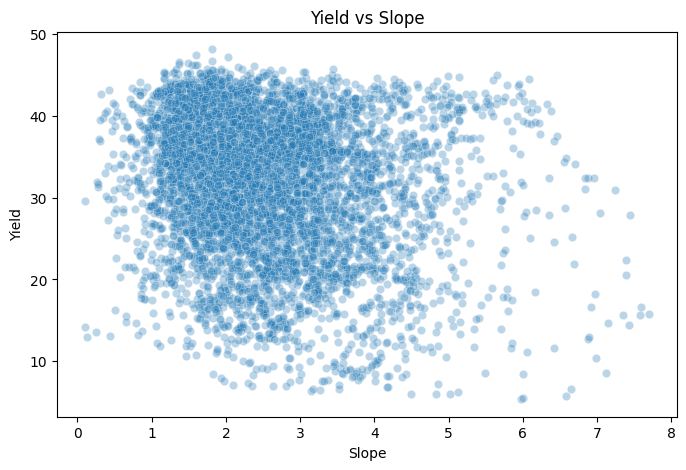

slope_bin
0–2    1955
2–4    3265
4–6     565
6–8      56
Name: count, dtype: int64


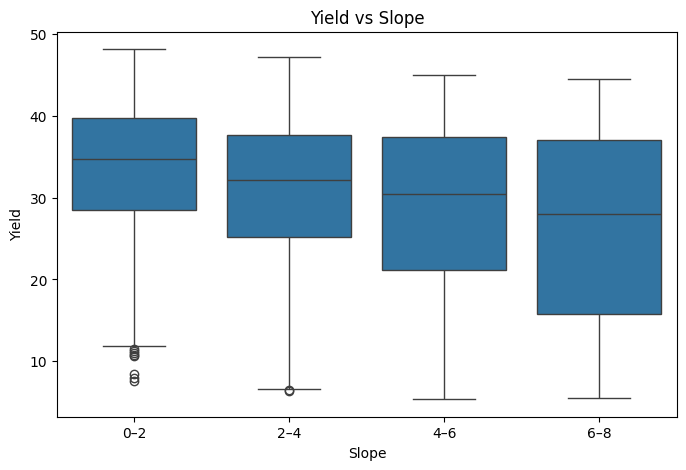

In [17]:
plt.figure(figsize = (8,5))
sns.scatterplot(data = df_yield, x = 'slope', y = "yield", alpha = 0.3)
plt.title("Yield vs Slope")
plt.xlabel("Slope")
plt.ylabel("Yield")
plt.show()


# Step 1: Define the bin edges (0 to 90 degrees, step of 10)
slope_bins = np.arange(0, 10, 2)  # This gives [0, 10, 20, ..., 90]

# Step 2: Define labels (e.g., "0–10", "10–20", ...)
slope_labels = [f"{slope_bins[i]}–{slope_bins[i+1]}" for i in range(len(slope_bins)-1)]

# Step 3: Create a new categorical column
df_yield["slope_bin"] = pd.cut(df_yield["slope"], bins=slope_bins, labels=slope_labels, include_lowest=True)

# Step 4: Preview
print(df_yield["slope_bin"].value_counts().sort_index())


#Box_plot
plt.figure(figsize = (8,5))
sns.boxplot(data = df_yield, x = 'slope_bin', y = "yield")
plt.title("Yield vs Slope")
plt.xlabel("Slope")
plt.ylabel("Yield")
plt.show()

## Scatter Plot of Yield vs Aspect

In [18]:
# Define bins and labels for compass directions
bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

# Create new categorical column
df_yield['aspect_bin'] = pd.cut(df_yield['aspect'], bins=bins, labels=labels, include_lowest=True)

# Check if it worked
print(df_yield['aspect_bin'].value_counts())

aspect_bin
NW    2119
N     1929
W     1236
SW     208
NE     196
E       85
S       39
SE      29
Name: count, dtype: int64


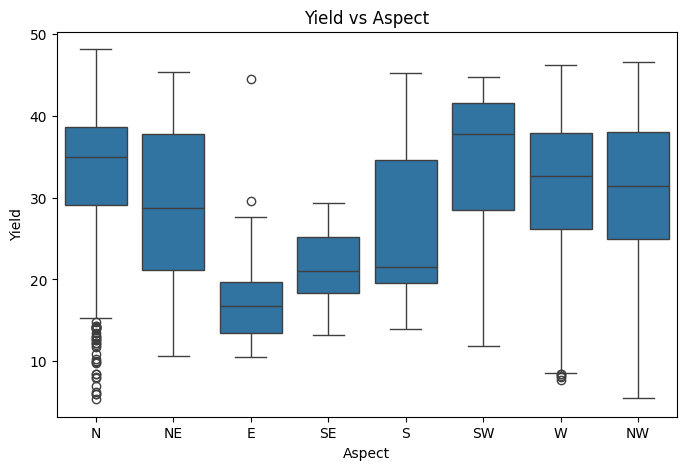

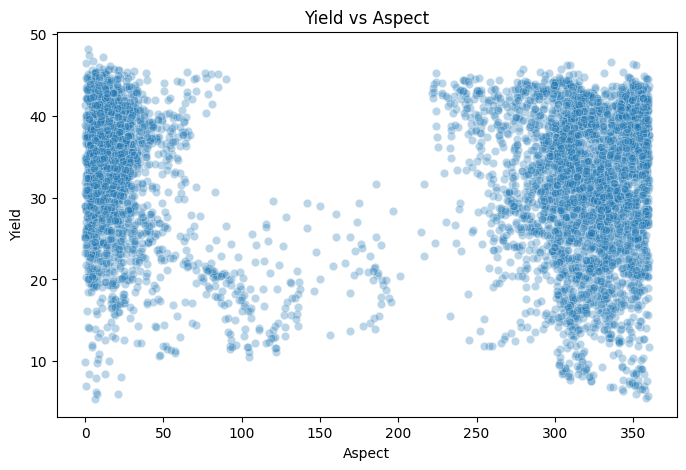

In [19]:
plt.figure(figsize = (8,5))
sns.boxplot(data = df_yield, x = 'aspect_bin', y = "yield")
plt.title("Yield vs Aspect")
plt.xlabel("Aspect")
plt.ylabel("Yield")
plt.show()

plt.figure(figsize = (8,5))
sns.scatterplot(data = df_yield, x = 'aspect', y = "yield", alpha = 0.3)
plt.title("Yield vs Aspect")
plt.xlabel("Aspect")
plt.ylabel("Yield")
plt.show()



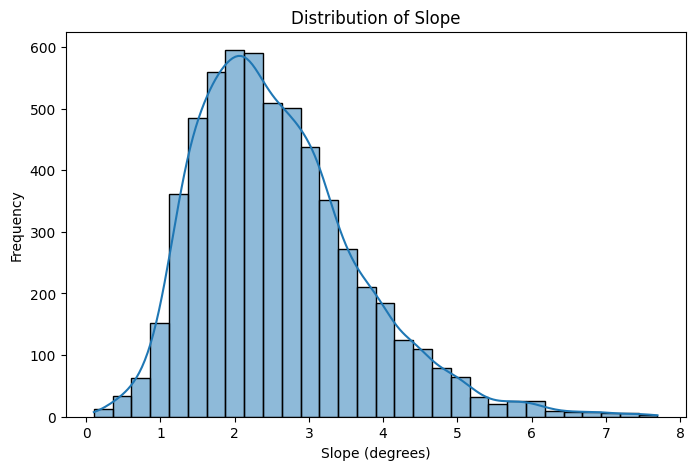

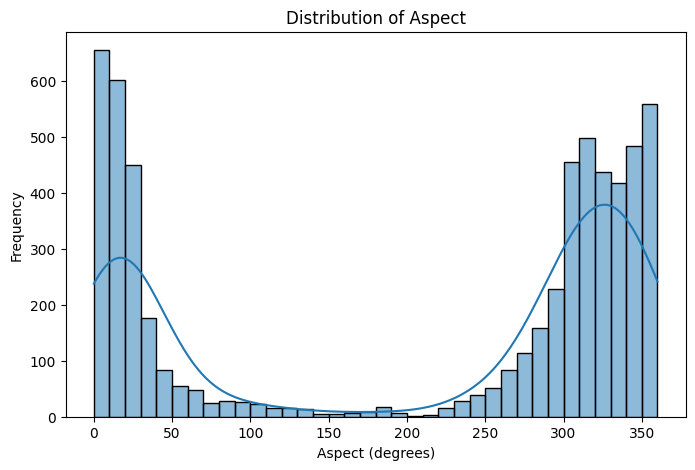

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df_yield['slope'], bins=30, kde=True)
plt.title("Distribution of Slope")
plt.xlabel("Slope (degrees)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_yield['aspect'], bins=36, kde=True)  # 36 bins for 10° intervals
plt.title("Distribution of Aspect")
plt.xlabel("Aspect (degrees)")
plt.ylabel("Frequency")
plt.show()


### Importing the NDVI Data



In [ ]:
print(df_yield.describe())

               row          col        yield              x             y  \
count  5841.000000  5841.000000  5841.000000    5841.000000  5.841000e+03   
mean     58.351139    43.564116    31.585623  337886.931191  4.320544e+06   
std      38.817197    18.863915     8.498373      94.965744  1.950757e+02   
min       0.000000     0.000000     5.354946  337667.618362  4.320179e+06   
25%      25.000000    30.000000    25.981806  337818.645986  4.320355e+06   
50%      47.000000    44.000000    32.964546  337889.125544  4.320601e+06   
75%      96.000000    60.000000    38.319359  337969.673610  4.320712e+06   
max     131.000000    75.000000    48.159290  338045.187422  4.320838e+06   

         elevation        slope       aspect  
count  5841.000000  5841.000000  5841.000000  
mean     37.136742     2.587424   206.555145  
std       6.113163     1.103131   145.686432  
min      27.557011     0.103452     0.036912  
25%      31.467188     1.782672    23.284977  
50%      36.064037     2

### Let's Test the model and check the metrics of the model

In [21]:
#importing hte metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#importing train test split
from sklearn.model_selection import train_test_split

#importing for the gridsearchCV
from sklearn.model_selection import GridSearchCV

### The R2 came out to be very small than expected, mostly because the yield was greatly right skewed
---

### Solving the right skewed nature of the yield data

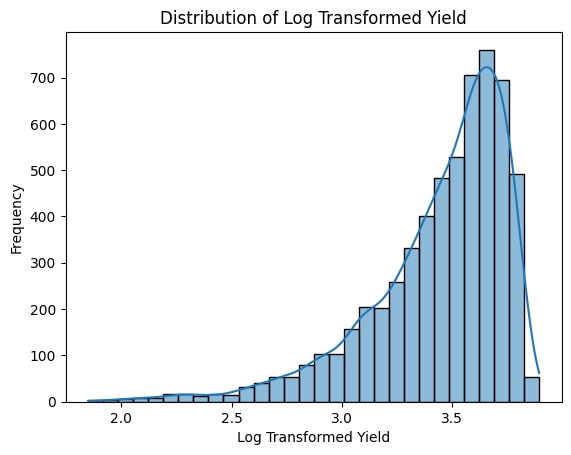

In [22]:
#log transformation of the target value
y = df_yield['yield']
y_log = np.log1p(y)
sns.histplot(y_log, bins=30, kde=True)
plt.title("Distribution of Log Transformed Yield")
plt.xlabel("Log Transformed Yield")
plt.ylabel("Frequency")
plt.show()

In [ ]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

NameError: name 'X' is not defined

In [ ]:
#hyper Parameter tuning criteria
param_grid = {
    'n_estimators': [100, 200],            # number of boosting rounds
    'max_depth': [3, 5, 7],                # depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],     # step size shrinkage
    'subsample': [0.7, 1],                 # fraction of samples to be used for each tree
    'colsample_bytree': [0.7, 1],          # fraction of features to be used per tree
}

XGB_Model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)



# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=XGB_Model,
    param_grid=param_grid,
    scoring='r2',            # Can also use 'neg_mean_absolute_error', 'neg_root_mean_squared_error', etc.
    cv=5,                    # 5-fold cross-validation
    verbose=1,
    n_jobs=-1                # Use all available cores
)

# Step 4: Fit the GridSearch to training data
grid_search.fit(X_train, y_train_log)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.7, 1]},
             scoring='r2', verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
Best R² Score: 0.6014627099037171


In [ ]:
best_model = grid_search.best_estimator_

# Predict on test set (still in log scale)
y_pred_log = best_model.predict(X_test)

y_pred = np.expm1(y_pred_log)     # inverse of np.log1p()
y_test_actual = np.expm1(y_test_log)  # if you transformed y_test before

In [ ]:

r2 = r2_score(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R² Score: 0.6192
Test MAE: 4.1081
Test RMSE: 5.3329


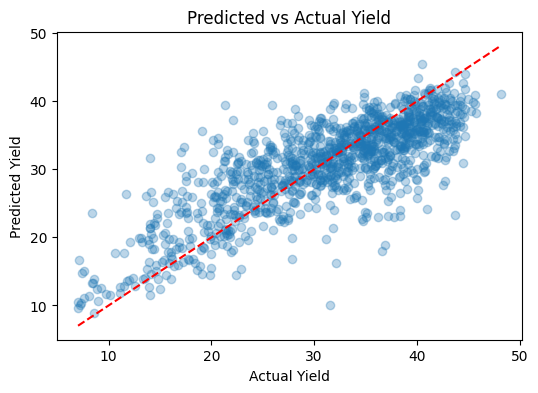

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(y_test_actual, y_pred, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield")
plt.show()


## Looking into Feature Engineering


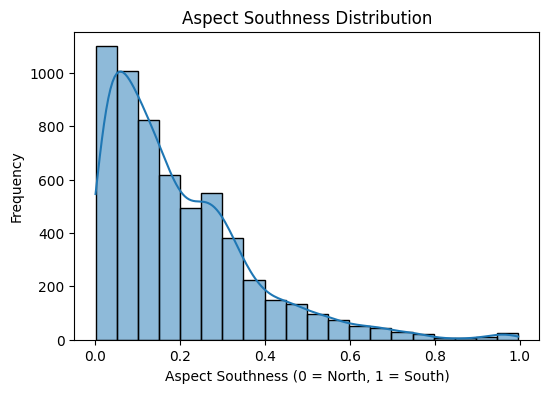

In [23]:
# Create aspect southness
df_yield['aspect_southness'] = 1 - np.abs((df_yield['aspect'] - 180) / 180)

# Drop raw aspect if you're replacing it
# df_yield.drop(columns='aspect', inplace=True)

# Optional: Check distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(df_yield['aspect_southness'], bins=20, kde=True)
plt.title("Aspect Southness Distribution")
plt.xlabel("Aspect Southness (0 = North, 1 = South)")
plt.ylabel("Frequency")
plt.show()

In [24]:

# Add polynomial features
df_yield['slope_squared'] = df_yield['slope'] ** 2
df_yield['elevation_squared'] = df_yield['elevation'] ** 2

# Add interaction features
df_yield['elev_slope'] = df_yield['elevation'] * df_yield['slope']
df_yield['elev_aspect'] = df_yield['elevation'] * df_yield['aspect_southness']
df_yield['slope_aspect'] = df_yield['slope'] * df_yield['aspect_southness']
features = [
    'elevation', 'slope', 'aspect_southness',
    'slope_squared', 'elevation_squared',
    'elev_slope', 'elev_aspect', 'slope_aspect'
]

print(df_yield.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5841 entries, 0 to 5840
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   row                5841 non-null   int64   
 1   col                5841 non-null   int64   
 2   yield              5841 non-null   float32 
 3   x                  5841 non-null   float64 
 4   y                  5841 non-null   float64 
 5   elevation          5841 non-null   float32 
 6   slope              5841 non-null   float32 
 7   aspect             5841 non-null   float32 
 8   slope_bin          5841 non-null   category
 9   aspect_bin         5841 non-null   category
 10  aspect_southness   5841 non-null   float32 
 11  slope_squared      5841 non-null   float32 
 12  elevation_squared  5841 non-null   float32 
 13  elev_slope         5841 non-null   float32 
 14  elev_aspect        5841 non-null   float32 
 15  slope_aspect       5841 non-null   float32 
dtypes: cat

## Training Model with the Engineered Features


In [ ]:
features = ['elevation', 'slope', 'aspect', 'aspect_southness', 'slope_aspect']
# features = ['slope', 'slope_aspect']

target = 'yield'

X = df_yield[features]
y = df_yield[target]

# Log-transform the target to handle skewness
y_log = np.log1p(y)

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("X Train Aspect: ", X_train.shape)
print("X Test: ", X_test.shape)
print("Y Train: ", y_train_log.shape)
print("Y Test: ", y_test_log.shape )

# print("===========================")
# print("X Train: ", X_train.head())
# print("X Test: ", X_test.head())
# print("Y Train: ", y_train_log.head())
# print("Y Test: ", y_test_log.head())

X Train Aspect:  (4672, 5)
X Test:  (1169, 5)
Y Train:  (4672,)
Y Test:  (1169,)


In [ ]:
#========================================================================================
import xgboost as xgb

#hyper Parameter tuning criteria
param_grid = {
    'n_estimators': [100, 200],            # number of boosting rounds
    'max_depth': [3, 5, 7],                # depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],     # step size shrinkage
    'subsample': [0.7, 1],                 # fraction of samples to be used for each tree
    'colsample_bytree': [0.7, 1],          # fraction of features to be used per tree
}

XGB_Model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)



# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=XGB_Model,
    param_grid=param_grid,
    scoring='r2',            # Can also use 'neg_mean_absolute_error', 'neg_root_mean_squared_error', etc.
    cv=5,                    # 5-fold cross-validation
    verbose=1,
    n_jobs=-1                # Use all available cores
)

# Step 4: Fit the GridSearch to training data
grid_search.fit(X_train, y_train_log)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R²:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Predict on holdout test set
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)


r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test R² Score: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=100,
    subsample=0.7,
    colsample_bytree=1,
    random_state=42
)

model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")


R²: 0.6243 | MAE: 4.0574 | RMSE: 5.2971


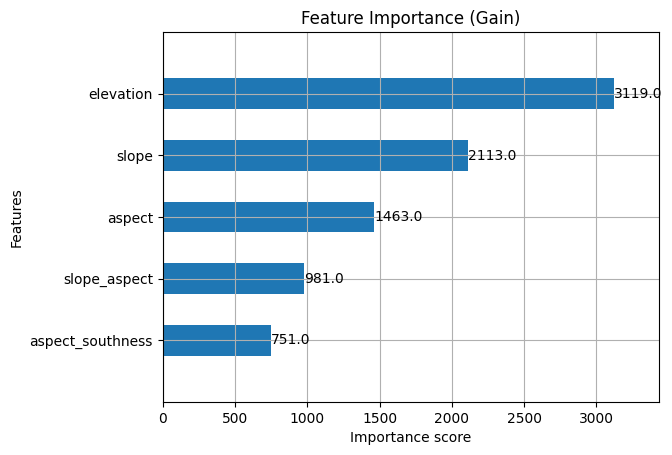

In [ ]:
xgb.plot_importance(model, height=0.5)
plt.title("Feature Importance (Gain)")
plt.show()


In [ ]:
# Get feature importance scores (gain-based)
importance = model.get_booster().get_score(importance_type='weight')

# Sort by importance (descending)
print(importance)
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

# Print as readable output
for feature, score in importance.items():
    print(f"{feature}: {score:.2f}")


{'elevation': 3119.0, 'slope': 2113.0, 'aspect': 1463.0, 'aspect_southness': 751.0, 'slope_aspect': 981.0}
elevation: 3119.00
slope: 2113.00
aspect: 1463.00
slope_aspect: 981.00
aspect_southness: 751.00


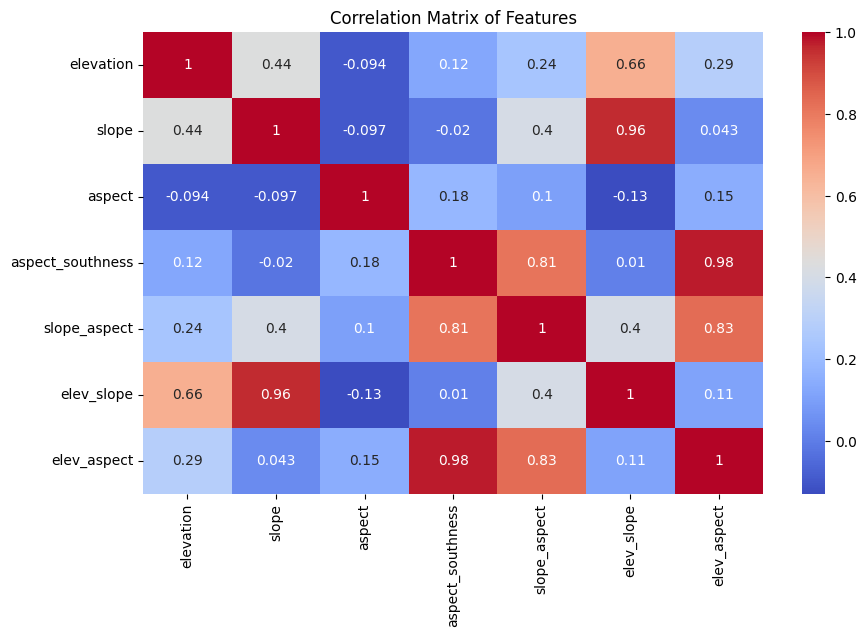

In [ ]:

# Only use numeric features
numeric_features = df_yield[['elevation', 'slope', 'aspect', 'aspect_southness', 'slope_aspect', 'elev_slope', 'elev_aspect']]

# Plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Prepare data (no NaNs)
X_vif = df_yield[['elevation', 'slope', 'aspect', 'aspect_southness', 'slope_aspect', 'elev_slope', 'elev_aspect']].dropna()
X_vif = add_constant(X_vif)  # adds intercept term

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

            Feature         VIF
0             const  371.554896
1         elevation   10.399706
2             slope   51.233833
3            aspect    1.091320
4  aspect_southness   48.649001
5      slope_aspect    7.290766
6        elev_slope   73.653419
7       elev_aspect   60.132781


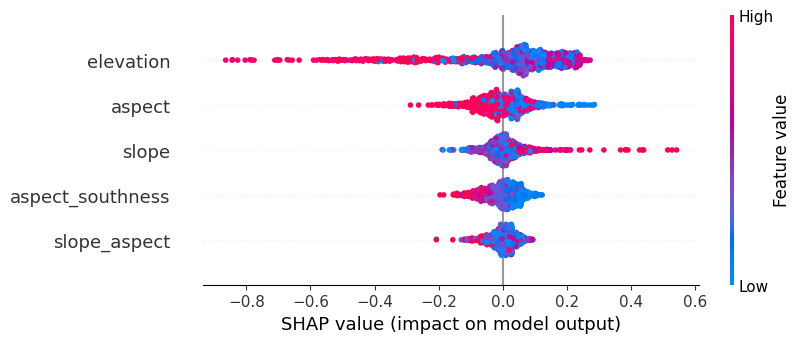

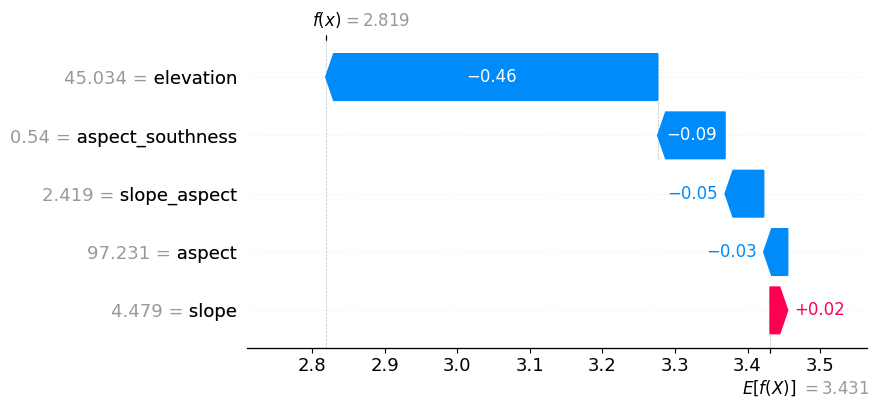

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(model, X_train)

# Get SHAP values for test data
shap_values = explainer(X_test)


# Global summary plot
shap.plots.beeswarm(shap_values)

# Individual prediction
shap.plots.waterfall(shap_values[0])


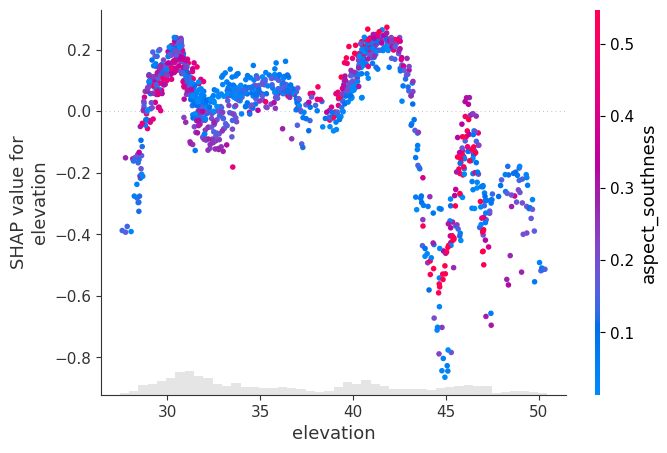

In [ ]:
shap.plots.scatter(shap_values[:, "elevation"], color=shap_values)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['elevation', 'slope', 'aspect', 'aspect_southness', 'slope_aspect']
X_scaled = StandardScaler().fit_transform(df_yield[features])


# Choose number of components (e.g., enough to explain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Check how much variance is explained
print("Explained variance per component:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

y_log = np.log1p(df_yield['yield'])

X_train_pca, X_test_pca, y_log_train, y_log_test = train_test_split(X_pca, y_log, test_size=0.2, random_state=42)


model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1,    max_depth=7,    n_estimators=100,    subsample=0.7,    colsample_bytree=1,    random_state=42)
model.fit(X_train_pca, y_log_train)

y_pred_log = model.predict(X_test_pca)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_log_test)

# Evaluation
print(f"Test R² Score: {r2_score(y_true, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_true, y_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")


Explained variance per component: [0.4124665  0.27758247 0.1718728  0.12200866]
Total variance explained: 0.9839304
Test R² Score: 0.4642
Test MAE: 4.9205
Test RMSE: 6.3257


In [ ]:

plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Component Variance")
plt.show()


### Trying to integrate NDVI Data in the model


In [25]:
!pip install earthengine-api
!pip install -U geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.3/631.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


In [26]:
import ee
import geemap

# Authenticate and initialize
ee.Authenticate()
# Replace 'your-google-cloud-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='cho-lab-prj')

In [27]:

# ===============================================================
# STEP 2: DEFINE THE AREA OF INTEREST (AOI)
# We define the specific field for which we want to get NDVI data.
# The coordinates are for a single, hypothetical field in Beltsville, MD.
# ===============================================================

# Define AOI polygon using WGS84 coordinates for a specific field
# (These are made-up coordinates for demonstration purposes)
aoi = ee.Geometry.Polygon(
    [[
        [-76.9079, 39.0203],  # Top-left
        [-76.9079, 39.0195],  # Bottom-left
        [-76.9071, 39.0195],  # Bottom-right
        [-76.9071, 39.0203],  # Top-right
        [-76.9079, 39.0203]   # Closing point (same as top-left)
    ]]
)


# ===============================================================
# STEP 3: FILTER SATELLITE IMAGERY AND CALCULATE NDVI
# This section loads the Sentinel-2 data, filters it, and
# computes the NDVI for each image.
# ===============================================================

# Function to calculate NDVI and add it as a new band to an image
def add_ndvi(image):
    # Use the NIR (Band 8) and Red (Band 4) bands for Sentinel-2
    # The normalizedDifference function computes (B8 - B4) / (B8 + B4)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Load the Sentinel-2 L2A Image Collection
# This collection is atmospherically corrected, which is ideal for NDVI.
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2022-01-01', '2022-12-31') \
    .filterBounds(aoi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .map(add_ndvi)

# Print the number of images in the filtered collection to verify we have data
print(f'Number of images in collection: {s2_collection.size().getInfo()}')


# ===============================================================
# STEP 4: VISUALIZE THE NDVI ON THE MAP
# This is the final step to display the results.
# ===============================================================

# Create a median composite of the NDVI values for the year 2022.
# This single image represents the "average" NDVI for each pixel over the year,
# which is good for a summary visualization.
median_ndvi = s2_collection.mean().select('NDVI')

# Define the visualization parameters for the NDVI.
# This color palette goes from red (low NDVI) to green (high NDVI)
# to make it easy to see vegetation health.
ndvi_vis_params = {
    'min': -0.2,
    'max': 1.0,
    'palette': [
        'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
        '74A901', '66A000', '529400', '3E8601', '207401', '056201',
        '004C00', '023B01', '012E01', '011D01', '011301'
    ]
}

# Initialize an interactive map object using geemap.
Map = geemap.Map()

# Add the median NDVI layer to the interactive map.
# We use .clip(aoi) to make sure the visualization is limited to
# the boundaries of our field.
Map.addLayer(median_ndvi.clip(aoi), ndvi_vis_params, 'Median NDVI 2022')

# Center the map on your area of interest with a specific zoom level (16).
Map.centerObject(aoi, 16)

# Display the map in the Colab notebook.
Map

Number of images in collection: 35


Map(center=[39.01989999994953, -76.9074999998531], controls=(WidgetControl(options=['position', 'transparent_b…

In [28]:
import altair as alt
%matplotlib inline


# ===============================================================
# STEP 2: DEFINE THE AREA OF INTEREST (AOI)
# We define the specific field for which we want to get NDVI data.
# The coordinates are for a single, hypothetical field in Beltsville, MD.
# ===============================================================

# Define AOI polygon using WGS84 coordinates for a specific field
aoi = ee.Geometry.Polygon(
    [[
        [-76.9079, 39.0203],  # Top-left
        [-76.9079, 39.0195],  # Bottom-left
        [-76.9071, 39.0195],  # Bottom-right
        [-76.9071, 39.0203],  # Top-right
        [-76.9079, 39.0203]   # Closing point (same as top-left)
    ]]
)


# ===============================================================
# STEP 3: FILTER SATELLITE IMAGERY AND CALCULATE NDVI
# This section loads the Sentinel-2 data, filters it, and
# computes the NDVI for each image.
# ===============================================================

# Function to calculate NDVI and add it as a new band to an image
def add_ndvi(image):
    # Use the NIR (Band 8) and Red (Band 4) bands for Sentinel-2
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Load the Sentinel-2 L2A Image Collection
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2022-01-01', '2022-12-31') \
    .filterBounds(aoi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .map(add_ndvi)

# print("S2 Collection: ", s2_collection)

print('Number of images in collection:', s2_collection.size().getInfo())




import altair as alt
import datetime

# Helper: extract NDVI mean and date for each image as a Feature
def extract_ndvi_feature(img):
    mean_dict = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        bestEffort=True
    )
    ndvi_mean = mean_dict.get('NDVI')
    date = img.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'NDVI': ndvi_mean})

# Apply to collection
ndvi_features = s2_collection.select('NDVI').map(extract_ndvi_feature)

# Convert to FeatureCollection and download as a list
feature_list = ndvi_features.aggregate_array('NDVI').getInfo()
date_list = ndvi_features.aggregate_array('date').getInfo()

# Convert to pandas DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(date_list),
    'NDVI': feature_list
})

# Drop any missing values
df = df.dropna()

# Plot using Altair
chart = alt.Chart(df).mark_line(point=True).encode(
    x='date:T',
    y='NDVI:Q'
).properties(
    title='NDVI Time Series for AOI in 2022'
)

chart



Number of images in collection: 35


alt.Chart(...)

In [29]:
import ee
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


# Create a GeoDataFrame from your pandas DataFrame
# The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
gdf_yield = gpd.GeoDataFrame(
    df_yield,
    geometry=gpd.points_from_xy(df_yield['x'], df_yield['y']),
    crs='EPSG:32617'  # Replace with the correct CRS for your data if different
)

# Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
# We also reset the index to a column so we can reliably merge later.
gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()


# --------------------------------------------------------------------------------
# Step 2: Define image processing functions for GEE
# --------------------------------------------------------------------------------

def add_ndvi(image):
    """
    A GEE server-side function to add a cloud mask and NDVI band to a Sentinel-2 image.
    This function is mapped over the entire image collection.
    """
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    image = image.updateMask(mask).divide(10000)

    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)


# --------------------------------------------------------------------------------
# Step 3: Process the data in batches to avoid server-side limits
# --------------------------------------------------------------------------------

batch_size = 500  # You can adjust this value based on your internet speed and data density
all_results = []
num_rows = len(gdf_yield_wgs84)

print(f"Starting to process {num_rows} points in batches of {batch_size}...")

for start_index in range(0, num_rows, batch_size):
    try:
        end_index = min(start_index + batch_size, num_rows)
        batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

        # Convert the current batch of points to a GEE FeatureCollection
        ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

        # Define the Sentinel-2 image collection and filter it by date and the batch's bounds
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate('2022-01-01', '2022-12-31') \
            .filterBounds(ee_feature_collection.geometry()) \
            .map(add_ndvi)

        # Compute the annual mean NDVI for each pixel over the entire time period.
        # This creates a single image where each pixel's value is the mean NDVI over the year.
        annual_mean_image = s2_collection.select('NDVI').mean()

        # Get the value for EACH point from the annual mean image.
        results = annual_mean_image.reduceRegions(
            collection=ee_feature_collection,
            reducer=ee.Reducer.mean(),
            scale=10
        )

        # Download the results for this batch and store them
        result_list = results.getInfo()['features']
        ndvi_data_batch = []
        for feature in result_list:
            ndvi_value = feature['properties'].get('mean')
            original_index = feature['properties'].get('index')
            ndvi_data_batch.append({'index': original_index, 'ndvi_mean_2022': ndvi_value})

        df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
        all_results.append(df_ndvi_batch)

        print(f"Batch {start_index} to {end_index} processed successfully.")

    except Exception as e:
        print(f"Error processing batch {start_index} to {end_index}: {e}")
        # Append an empty DataFrame to maintain consistency if a batch fails
        all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean_2022']))


# --------------------------------------------------------------------------------
# Step 4: Combine all batch results and merge with the original DataFrame
# --------------------------------------------------------------------------------

if all_results:
    # Concatenate all batch results into one master DataFrame
    df_all_ndvi = pd.concat(all_results, ignore_index=True)
else:
    df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean_2022'])

# Merge the new NDVI data with your original DataFrame based on the index
df_yield_with_index = df_yield.reset_index()
df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
df_final = df_final.set_index('index')

# Final check of the DataFrame
print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
print(df_final.head())
print(f"\nFinal DataFrame shape: {df_final.shape}")

Starting to process 5841 points in batches of 500...
Batch 0 to 500 processed successfully.
Batch 500 to 1000 processed successfully.
Batch 1000 to 1500 processed successfully.
Batch 1500 to 2000 processed successfully.
Batch 2000 to 2500 processed successfully.
Batch 2500 to 3000 processed successfully.
Batch 3000 to 3500 processed successfully.
Batch 3500 to 4000 processed successfully.
Batch 4000 to 4500 processed successfully.
Batch 4500 to 5000 processed successfully.
Batch 5000 to 5500 processed successfully.
Batch 5500 to 5841 processed successfully.

Processing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:
       row  col      yield              x             y  elevation     slope  \
index                                                                          
0        0   63  31.364374  337984.776372  4.320838e+06  29.970028  0.862994   
1        0   64  29.821093  337989.810626  4.320838e+06  29.873554  1.250407   
2        0   65  2

In [30]:
print("df_yield: ", df_final.head())

df_yield:         row  col      yield              x             y  elevation     slope  \
index                                                                          
0        0   63  31.364374  337984.776372  4.320838e+06  29.970028  0.862994   
1        0   64  29.821093  337989.810626  4.320838e+06  29.873554  1.250407   
2        0   65  27.940876  337994.844880  4.320838e+06  29.741947  1.508874   
3        0   66  25.964394  337999.879134  4.320838e+06  29.558409  1.667183   
4        0   67  25.181866  338004.913389  4.320838e+06  29.367819  1.695179   

          aspect slope_bin aspect_bin  aspect_southness  slope_squared  \
index                                                                    
0      45.548988       0–2         NE          0.253050       0.744759   
1      59.525551       0–2         NE          0.330697       1.563519   
2      67.985176       0–2         NE          0.377695       2.276700   
3      66.825592       0–2         NE          0.371253   

In [31]:
print(df_final['ndvi_mean_2022'].min())

0.13910013437271118


In [32]:
features = ['elevation', 'slope', 'aspect', 'aspect_southness', 'slope_aspect', 'ndvi_mean_2022']
# features = ['slope', 'slope_aspect']

target = 'yield'

X = df_final[features]
y = df_final[target]

# Log-transform the target to handle skewness
y_log = np.log1p(y)

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print("X Train Aspect: ", X_train.shape)
print("X Test: ", X_test.shape)
print("Y Train: ", y_train_log.shape)
print("Y Test: ", y_test_log.shape )

# print("===========================")
# print("X Train: ", X_train.head())
# print("X Test: ", X_test.head())
# print("Y Train: ", y_train_log.head())
# print("Y Test: ", y_test_log.head())

import xgboost as xgb

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=100,
    subsample=0.7,
    colsample_bytree=1,
    random_state=42
)

model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

X Train Aspect:  (4672, 6)
X Test:  (1169, 6)
Y Train:  (4672,)
Y Test:  (1169,)
R²: 0.7715 | MAE: 3.1229 | RMSE: 4.1311


In [66]:
# hyperparameter_tuning_xgboost_verbose_cpu.py
# ─────────────────────────────────────────────────────────────────────────
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform

# ── data prep ───────────────────────────────────────────────────────────
features = ['elevation', 'slope', 'aspect',
            'aspect_southness', 'slope_aspect', 'ndvi_mean_2022']
target = 'yield'

X = df_final[features]
y = np.log1p(df_final[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ── wide search space ───────────────────────────────────────────────────
param_dist = {
    "max_depth"        : randint(3, 10),
    "min_child_weight" : randint(1, 35),
    "gamma"            : uniform(0, 1.0),
    "subsample"        : uniform(0.5, 0.5),
    "colsample_bytree" : uniform(0.5, 0.5),
    "reg_lambda"       : loguniform(1e-2, 1e2),
    "reg_alpha"        : loguniform(1e-3, 1),
    "learning_rate"    : loguniform(1e-3, 3e-1),
    "n_estimators"     : randint(400, 2001)
}

# ── base estimator — note device="cpu" & n_jobs=1 ───────────────────────
base = xgb.XGBRegressor(
    objective   = "reg:squarederror",
    eval_metric = "mae",
    tree_method = "hist",        # fastest CPU algorithm
    device      = "cpu",         # <─ keeps the code off GPU
    n_jobs      = 1,             # each fit uses 1 core; joblib handles outer parallelism
    verbosity   = 1,
    random_state= 42
)

search = RandomizedSearchCV(
    estimator           = base,
    param_distributions = param_dist,
    n_iter     = 200,            # try 200 first; 1000 can be multi-hour
    scoring    = "r2",
    cv         = 5,
    verbose    = 2,              # search-level progress
    n_jobs     = -1,
    random_state = 42,
    error_score = "raise"
)

# XGBoost prints every 100 trees inside each fit
search.fit(X_train, y_train, verbose=100)

print("\n──── best params (RandomizedSearchCV) ────")
for k, v in search.best_params_.items():
    print(f"{k:18}: {v}")
print("CV-mean R² :", round(search.best_score_, 4))

# ── retrain best model WITH early stopping ──────────────────────────────
best_params = search.best_params_.copy()
best_params.update({
    "objective"            : "reg:squarederror",
    "eval_metric"          : "mae",
    "tree_method"          : "hist",
    "device"               : "cpu",
    "n_jobs"               : 1,
    "early_stopping_rounds": 50,
    "verbosity"            : 1,
    "random_state"         : 42
})

final_model = xgb.XGBRegressor(**best_params)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

final_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=100
)

print(f"\nStopped after {final_model.best_iteration} boosting rounds")

# ── evaluate on Train / Val / Test (original scale) ─────────────────────
def inv_log1p(a): return np.expm1(a)
def report(tag, X_, y_):
    y_hat = inv_log1p(
        final_model.predict(X_, iteration_range=(0, final_model.best_iteration))
    )
    y_true = inv_log1p(y_)
    print(f"{tag:6} R²: {r2_score(y_true, y_hat):.3f}   "
          f"MAE: {mean_absolute_error(y_true, y_hat):.3f}   "
          f"RMSE: {mean_squared_error(y_true, y_hat}")

print("\n──── performance (yield units) ───────────────────────────────")
report("Train", X_tr,  y_tr)
report("Val",   X_val, y_val)
report("Test",  X_test, y_test)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits

──── best params (RandomizedSearchCV) ────
colsample_bytree  : 0.9870823143140077
gamma             : 0.02002635592582447
learning_rate     : 0.06700154293855284
max_depth         : 6
min_child_weight  : 1
n_estimators      : 685
reg_alpha         : 0.03654886811640331
reg_lambda        : 3.1213520322039905
subsample         : 0.5445622160580084
CV-mean R² : 0.7505
[0]	validation_0-mae:0.25286
[100]	validation_0-mae:0.13035
[200]	validation_0-mae:0.12034
[300]	validation_0-mae:0.11709
[400]	validation_0-mae:0.11539
[500]	validation_0-mae:0.11411
[600]	validation_0-mae:0.11347
[684]	validation_0-mae:0.11326

Stopped after 675 boosting rounds

──── performance (yield units) ───────────────────────────────


TypeError: got an unexpected keyword argument 'squared'

In [69]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

# ---------------------------------------------------------------------
# 1 ▸ Data split (train ▸ val ▸ test)
# ---------------------------------------------------------------------
features = [
    "elevation", "slope", "aspect",
    "aspect_southness", "slope_aspect", "ndvi_mean_2022"
]
target = "yield"

X = df_final[features]
y = np.log1p(df_final[target])          # log-transform yield

# 20 % hold-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 20 % of training data reserved for validation monitoring
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42
)

# ---------------------------------------------------------------------
# 2 ▸ Final model with tuned parameters + early stopping
# ---------------------------------------------------------------------
best_params = dict(
    # tuned hyper-parameters
    colsample_bytree = 0.9870823143140077,
    gamma            = 0.02002635592582447,
    learning_rate    = 0.06700154293855284,
    max_depth        = 6,
    min_child_weight = 1,
    n_estimators     = 685,                 # large enough; ES may stop earlier
    reg_alpha        = 0.03654886811640331,
    reg_lambda       = 3.1213520322039905,
    subsample        = 0.5445622160580084,
    # fixed settings
    objective        = "reg:squarederror",
    eval_metric      = "mae",
    tree_method      = "hist",              # fastest CPU algorithm
    device           = "cpu",               # remove if you have a GPU + gpu_hist
    early_stopping_rounds = 50,
    random_state     = 42,
    verbosity        = 1,                   # 0=silent, 1=warning, 2=info
)

model = XGBRegressor(**best_params)

model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],             # monitor validation only
    verbose=100                            # print every 100 boosting rounds
)

best_iter = model.best_iteration
print(f"\nStopped after {best_iter} boosting rounds")

# ---------------------------------------------------------------------
# 3 ▸ Metrics on Train ▸ Val ▸ Test (original yield scale)
# ---------------------------------------------------------------------
def report(tag, X_, y_):
    y_hat  = np.expm1(model.predict(X_, iteration_range=(0, best_iter)))
    y_true = np.expm1(y_)
    r2  = r2_score(y_true, y_hat)
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(((y_true - y_hat) ** 2).mean())     # sklearn<0.22 safe
    print(f"{tag:6} R²: {r2:.3f}   MAE: {mae:.3f}   RMSE: {rmse:.3f}")

print("\n──── performance (yield units) ──────────────────────────")
report("Train", X_tr,  y_tr)
report("Val",   X_val, y_val)
report("Test",  X_test, y_test)


[0]	validation_0-mae:0.24565
[100]	validation_0-mae:0.12881
[200]	validation_0-mae:0.11716
[300]	validation_0-mae:0.11408
[400]	validation_0-mae:0.11259
[500]	validation_0-mae:0.11169
[600]	validation_0-mae:0.11110
[684]	validation_0-mae:0.11058

Stopped after 678 boosting rounds

──── performance (yield units) ──────────────────────────
Train  R²: 0.913   MAE: 1.899   RMSE: 2.467
Val    R²: 0.758   MAE: 3.254   RMSE: 4.304
Test   R²: 0.745   MAE: 3.323   RMSE: 4.362


In [71]:
import joblib


joblib_path = "/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/ML_models/xgb_ylog_model_with_topography_and_ndvi.pkl"
joblib.dump(model, joblib_path)
print(f"✅ Joblib model saved → {joblib_path}")

✅ Joblib model saved → /content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/ML_models/xgb_ylog_model_with_topography_and_ndvi.pkl


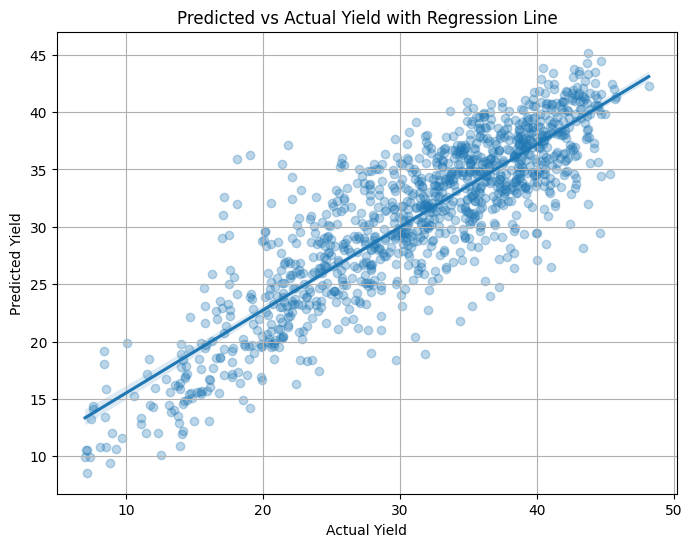

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=np.expm1(y_test), y=np.expm1(model.predict(X_test, iteration_range=(0, best_iter))), scatter_kws={'alpha':0.3})
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield with Regression Line")
# plt.text(0.05, 0.9, f"R² = {r2_score(y_test_orig, y_pred):.2f} \nMAE = {mean_absolute_error(y_test_orig, y_pred):.2f}", transform=plt.gca().transAxes)
plt.grid(True)
plt.show()